In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Raw Stock Data Input

In [230]:
raw = pd.read_csv('NVDA_5yr.csv')
# Data Source: https://finance.yahoo.com/quote/NVDA/history?p=NVDA&guccounter=1

# EDA

In [231]:
raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-23,49.445000,49.712502,48.950001,49.154999,48.637718,42869600
1,2017-10-24,49.247501,49.687500,48.985001,49.669998,49.147293,40724400
2,2017-10-25,49.270000,49.805000,47.792500,48.415001,47.905499,82816000
3,2017-10-26,48.695000,49.040001,48.452499,48.922501,48.407654,32274400
4,2017-10-27,49.450001,50.467499,49.187500,50.465000,49.933937,57219200


In [232]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [233]:
df1=raw.reset_index()['Close']

In [234]:
df1

0        49.154999
1        49.669998
2        48.415001
3        48.922501
4        50.465000
           ...    
1254    118.879997
1255    119.669998
1256    120.510002
1257    121.940002
1258    124.660004
Name: Close, Length: 1259, dtype: float64

### Time Series of Closing Price

Text(0.5, 1.0, 'NVDA Closing Price')

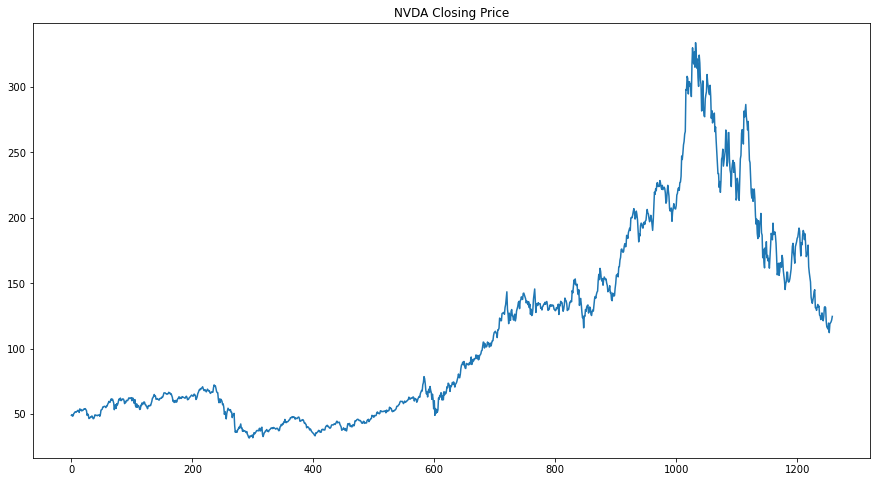

In [235]:
plt.figure(figsize = (15,8))
plt.plot(df1)
plt.title ('NVDA Closing Price')

In [138]:
# Trend Reversal: Macro data will probably be useful here?

# Features Scaling

In [236]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.05756813]
 [0.05927348]
 [0.05511772]
 ...
 [0.29385079]
 [0.29858604]
 [0.30759297]]


# Train-Test Split

In [237]:
N = len(df1)
cutoff = int(0.65*N)
df_train = df1[:cutoff,:]
df_test = df1[cutoff:,:]

In [238]:
df_train.shape, df_test.shape

((818, 1), (441, 1))

# Creating Data Structure for LSTM

In [239]:
# def function to tranform data
def create_LSTM(data, timestep):
    dataX, dataY = [], []
    N = len(data)
    for i in range(N - timestep - 1):
        a = data[i:(i+timestep),0]
        dataX.append(a)
        dataY.append(data[i+timestep,0])
    return np.array(dataX), np.array(dataY)

In [240]:
# use function to tranform train&test
timestep = 100 # based on trials-error
X_train, y_train = create_LSTM(df_train, timestep)
X_test, y_test = create_LSTM(df_test, timestep)

In [241]:
# check structure
print(X_train.shape)

(717, 100)


In [242]:
# reshape input for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
#print(X_train)

# Create LSTM model

In [243]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [244]:
# Initialising stacked LSTM model
lstm = Sequential()

In [245]:
# Add LSTM Layers
lstm.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
lstm.add(LSTM(50, return_sequences = True))
lstm.add(LSTM(50))

# early stop
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Add output layer
lstm.add(Dense(1))

# Compile
lstm.compile(loss = 'mean_squared_error', optimizer = 'adam')

lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_21 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_22 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### Training

In [246]:
model = lstm.fit(x = X_train, y = y_train, batch_size = 60, epochs = 30, validation_data=(X_test, y_test), 
                 verbose = 1,callbacks=[early_stop])

Epoch 1/30
12/12 [==============================] - 8s 259ms/step - loss: 0.0074 - val_loss: 0.0426
Epoch 2/30
12/12 [==============================] - 2s 152ms/step - loss: 0.0013 - val_loss: 0.0068
Epoch 3/30
12/12 [==============================] - 2s 150ms/step - loss: 6.2325e-04 - val_loss: 0.0066
Epoch 4/30
12/12 [==============================] - 2s 144ms/step - loss: 3.7813e-04 - val_loss: 0.0071
Epoch 5/30
12/12 [==============================] - 2s 145ms/step - loss: 3.2481e-04 - val_loss: 0.0062
Epoch 6/30
12/12 [==============================] - 2s 143ms/step - loss: 3.1023e-04 - val_loss: 0.0061
Epoch 7/30
12/12 [==============================] - 2s 148ms/step - loss: 2.9662e-04 - val_loss: 0.0060
Epoch 8/30
12/12 [==============================] - 2s 142ms/step - loss: 2.9716e-04 - val_loss: 0.0060
Epoch 9/30
12/12 [==============================] - 2s 141ms/step - loss: 2.9116e-04 - val_loss: 0.0058
Epoch 10/30
12/12 [==============================] - 2s 138ms/step - los

# Validation using Test Set

In [150]:
import tensorflow as tf

In [247]:
# predict
train_predict = lstm.predict(X_train)
test_predict = lstm.predict(X_test)

11/11 [==============================] - 0s 23ms/step


In [248]:
# tranform back
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [250]:
# check RMSE
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

76.26672582158571

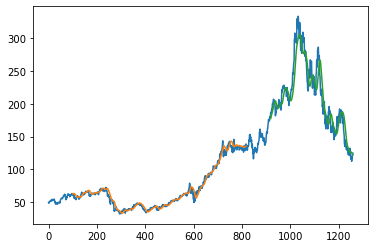

In [251]:
# Visualisation

look_back=timestep
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [252]:
N = len(df_test)
N

441

In [253]:
x_input=df_test[N-timestep:].reshape(1,-1)
x_input.shape

(1, 100)

In [254]:
temp_input=list(x_input)[0].tolist()

# Prediction Next 10 Days

In [255]:
lst_output=[]
n_steps=timestep
i=0
while(i<10):
    
    if(len(temp_input)>timestep):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = lstm.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = lstm.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.2957009]
101
1 day input [0.54356102 0.51468589 0.51687141 0.5215073  0.5123017  0.49243349
 0.45686943 0.41292757 0.41918606 0.44206762 0.41140432 0.42064306
 0.44335905 0.43653764 0.43206727 0.46190268 0.45339249 0.42402067
 0.40945062 0.39676808 0.37570778 0.39031092 0.39580781 0.41991456
 0.4192523  0.39653631 0.39421836 0.39693366 0.40382131 0.41673562
 0.42796116 0.45746546 0.48445313 0.49249974 0.46829364 0.45852512
 0.44226629 0.48389016 0.49031422 0.4962416  0.5054472  0.50826183
 0.52041454 0.53107715 0.52359348 0.4839895  0.46057815 0.49405608
 0.48892345 0.51432164 0.52501739 0.51995095 0.50193715 0.51644091
 0.4858439  0.45885623 0.46372394 0.46508161 0.48796318 0.43322627
 0.41802706 0.4070002  0.39461571 0.35630316 0.34670021 0.3406735
 0.34891882 0.35805818 0.37120432 0.37511176 0.32961355 0.32951421
 0.32292457 0.33183216 0.33792511 0.33110365 0.33391833 0.31073876
 0.30924865 0.2997119  0.30583792 0.31653365 0.29944698 0.29676478
 0.3091162  0.33080564 0.33219641 0

In [256]:
day_input = np.arange(1,timestep+1)
day_output = np.arange(timestep+1,timestep+11)

In [257]:
len(df1)

1259

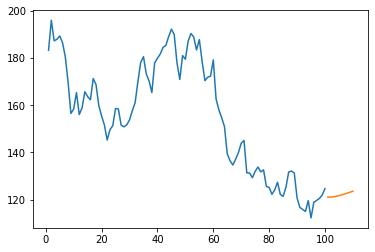

In [258]:
plt.plot(day_input, scaler.inverse_transform(df1[(len(df1)-timestep):]))
plt.plot(day_output, scaler.inverse_transform(lst_output))

In [266]:
#d = {'Index':list(range(10)),'Close':scaler.inverse_transform(lst_output[:,0])}
final_pred = pd.DataFrame(scaler.inverse_transform(lst_output))
final_pred

,0
0,121.068720
1,121.045194
2,121.174155
3,121.405923
4,121.703103
5,122.039910
6,122.399839
7,122.773456
8,123.155884
9,123.545125


In [278]:
final_pred['Index']=list(range(10))
final_pred.set_index('Index', inplace=True)
final_pred.columns = ['Close']
final_pred

,Close
Index,
0,121.068720
1,121.045194
2,121.174155
3,121.405923
4,121.703103
5,122.039910
6,122.399839
7,122.773456
8,123.155884


# Output

In [279]:
final_pred.to_csv('Pan_Yumo_Impl_1.csv')